In [1]:
import numpy as np
import tncontract as tn
import qutip as qt
import time
from itertools import product
from functools import reduce

from scipy.stats import cumfreq
from copy import deepcopy
from IPython.display import clear_output

from src.simulation_utils import *
from src.plotting_utils import *

In [17]:
n_sites = 4
X = qt.sigmax()
I = qt.qeye(2)
XX = qt.tensor(X, X)
H = sum([local_operator(i, XX, n_sites) for i in range(n_sites-1)])
zero = qt.operator_to_vector(qt.ket2dm(reduce(qt.tensor, [qt.basis(2,0)] * n_sites)))
# one = reduce(qt.tensor, [qt.basis(2,1)] * n_sites)

# Ising-like background noise
background = 1e-4
crosstalk_ham = sum([background * np.random.randn() * local_operator(i, XX, n_sites) for i in range(n_sites-1)])

# some bigger systematic nonlocal couplings
systematic = 1e-2
# crosstalk_ham += systematic * np.random.randn() * reduce(qt.tensor, [I,X,I,I,X,I])#,I])
crosstalk_ham += systematic * np.random.randn() * reduce(qt.tensor, [X,I,X,I])#,X,I])#,I])
crosstalk_ham += systematic * np.random.randn() * reduce(qt.tensor, [X,I,I,X])#,I,X])#,X])

crosstalk = qt.to_super(qt.propagator(crosstalk_ham, 3*np.pi/2))

In [18]:
crosstalk

Quantum object: dims = [[[2, 2, 2, 2], [2, 2, 2, 2]], [[2, 2, 2, 2], [2, 2, 2, 2]]], shape = (256, 256), type = super, isherm = False
Qobj data =
[[ 9.98771052e-01+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  2.74954796e-10+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  9.98771052e-01+0.00000000e+00j
  -3.88931903e-04-2.00123067e-04j ...  9.62433658e-11-1.20816676e-09j
   2.74954796e-10+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j -3.88931903e-04-2.00123067e-04j
   9.98771052e-01+0.00000000e+00j ...  2.74954796e-10+2.52435490e-28j
   9.62433658e-11-1.20816676e-09j  0.00000000e+00+0.00000000e+00j]
 ...
 [ 0.00000000e+00+0.00000000e+00j  9.62433658e-11-1.20816676e-09j
   2.74954796e-10-1.51461294e-28j ...  9.98771052e-01+0.00000000e+00j
  -3.88931903e-04-2.00123067e-04j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  2.

In [20]:
dep = (.99) * np.eye(4 ** n_sites, 4 ** n_sites) 
dep[0,0] = 1
dep_super = ptm_to_super(dep)
depolarising = qt.Qobj(dep_super, dims=crosstalk.dims, type=super)

In [21]:
depolarising

Quantum object: dims = [[[2, 2, 2, 2], [2, 2, 2, 2]], [[2, 2, 2, 2], [2, 2, 2, 2]]], shape = (256, 256), type = super, isherm = True, superrep = None
Qobj data =
[[9.90625e-01 0.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  6.25000e-04]
 [0.00000e+00 9.90000e-01 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [0.00000e+00 0.00000e+00 9.90000e-01 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 ...
 [0.00000e+00 0.00000e+00 0.00000e+00 ... 9.90000e-01 0.00000e+00
  0.00000e+00]
 [0.00000e+00 0.00000e+00 0.00000e+00 ... 0.00000e+00 9.90000e-01
  0.00000e+00]
 [6.25000e-04 0.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  9.90625e-01]]

In [23]:
u1,u2 = random_two_qubit_gate_ladder_qutip(6)

In [24]:
u1.dims

[[[2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2]],
 [[2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2]]]

In [25]:
one_qubit_layer1 = random_single_qubit_layer_qutip(n_sites)

In [26]:
one_qubit_layer1.dims

[[[2, 2, 2, 2], [2, 2, 2, 2]], [[2, 2, 2, 2], [2, 2, 2, 2]]]

In [14]:
zero

Quantum object: dims = [[[2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2]], [1]], shape = (4096, 1), type = operator-ket
Qobj data =
[[1.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]

In [11]:
slice_separation = 4

In [33]:
cct_depth = 10

specs = []
depths = []

noise = crosstalk
psi = zero

for j in range(cct_depth):
    one_qubit_layer1 = random_single_qubit_layer_qutip(n_sites)
    one_qubit_layer2 = random_single_qubit_layer_qutip(n_sites)
    two_qubit_layer1, two_qubit_layer2 = random_two_qubit_gate_ladder_qutip(n_sites)
    psi = two_qubit_layer2 * noise * one_qubit_layer2 * noise * two_qubit_layer1 * noise *  one_qubit_layer1 * noise * psi

    if 4*j % slice_separation == 0:
        depths.append(4*j)
        prob_vec = abs(np.diag(qt.vector_to_operator(psi).full())) ** 2
        specs.append(prob_vec)


In [34]:
x = np.logspace(-5,-1, 1000)
porter_thomas = 1-np.exp(-(2 ** n_sites) * x)

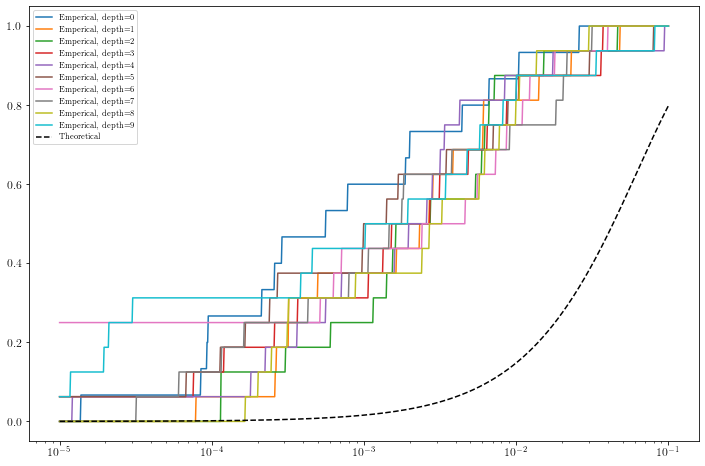

In [35]:
nplots = len(specs)
fig,ax = plt.subplots(figsize=(12,8))
for speckle,d in zip(specs,depths):
    ax.set_xscale('log')
    ax.plot(x, cumulative(speckle, x), label="Emperical, depth={}".format(d))
ax.plot(x, porter_thomas, 'k--', label="Theoretical")
ax.legend()
plt.show()